In [68]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We now use 6 wires:
# wires 0,1,2: input bits (a, b, c)
# wire 3: output for f
# wire 4: output for g
# wire 5: ancilla for multi-controlled gates
n_wires = 6
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

@qml.qnode(dev)
def oracle_circuit(inputs):
    """
    Oracle implementing:
      f(a,b,c) = ¬b ∧ (a ∨ ¬c)
      g(a,b,c) = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
      
    This circuit uses only Hadamard, PauliX, CNOT, and Toffoli gates.
    """
    # --- Prepare the input state on wires 0, 1, 2 (a, b, c) ---
    for i, bit in enumerate(inputs):
       if bit == 1:
           qml.PauliX(wires=i)
    
    ### Compute f on wire 3 = ¬b ∧ (a ∨ ¬c)
    # If b == 0 then set f to 1.
    # Use an X on wire 1 to control on b == 0.
    qml.PauliX(wires=1)         # b: 0 -> 1 (control becomes active)
    qml.CNOT(wires=[1, 3])      # If flipped b==1, then flip f.
    qml.Toffoli(wires=[5, 2, 3])

    # Restore b.
    qml.PauliX(wires=1)
    
    ### Compute g on wire 4 = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
    # Term 1: If a==1 and c==0 then flip g.
    qml.PauliX(wires=2)         # Flip c so that c==0 becomes 1 (control on ¬c).
    qml.Toffoli(wires=[0, 2, 4])
    qml.PauliX(wires=2)         # Restore c.
    
    # Term 2: If a==0, b==1, and c==1 then flip g.
    # Flip a only if it is 0 so that we control on ¬a.
    if inputs[0] == 0:
        qml.PauliX(wires=0)
    qml.Toffoli(wires=[0, 1, 5])
    qml.Toffoli(wires=[5, 2, 4])
    
    return qml.sample(wires=[3, 4])

In [69]:
def test_oracle():
    """Verify that the oracle returns the correct outputs for each input.
    
    The truth table is defined as a list of tuples:
      (a, b, c, expected_f, expected_g)
    where `None` means "don't care".
    """
    truth_table = [
        (0, 0, 0, 1, None),  # For (0,0,0): f=1, g is don't care.
        (0, 0, 1, None, 0),
        (0, 1, 0, 0, 0),
        (0, 1, 1, 0, 1),
        (1, 0, 0, 1, 1),
        (1, 0, 1, 1, 0),
        (1, 1, 0, None, 1),
        (1, 1, 1, 0, None)
    ]
    
    for a, b, c, expected_f, expected_g in truth_table:
        # Run the circuit for the given input triple.
        # (The circuit returns an array of shape (shots, 2).)
        result = oracle_circuit([a, b, c])
        
        # Take the majority vote (via mean and rounding) over the shots.
        f = int(np.round(np.mean(result[:, 0])))
        g = int(np.round(np.mean(result[:, 1])))
        
        if expected_f is not None:
            assert f == expected_f, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected f={expected_f}, got f={f}"
            )
        if expected_g is not None:
            assert g == expected_g, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected g={expected_g}, got g={g}"
            )
    print("All tests passed!")

# Run the test function.
test_oracle()


All tests passed!


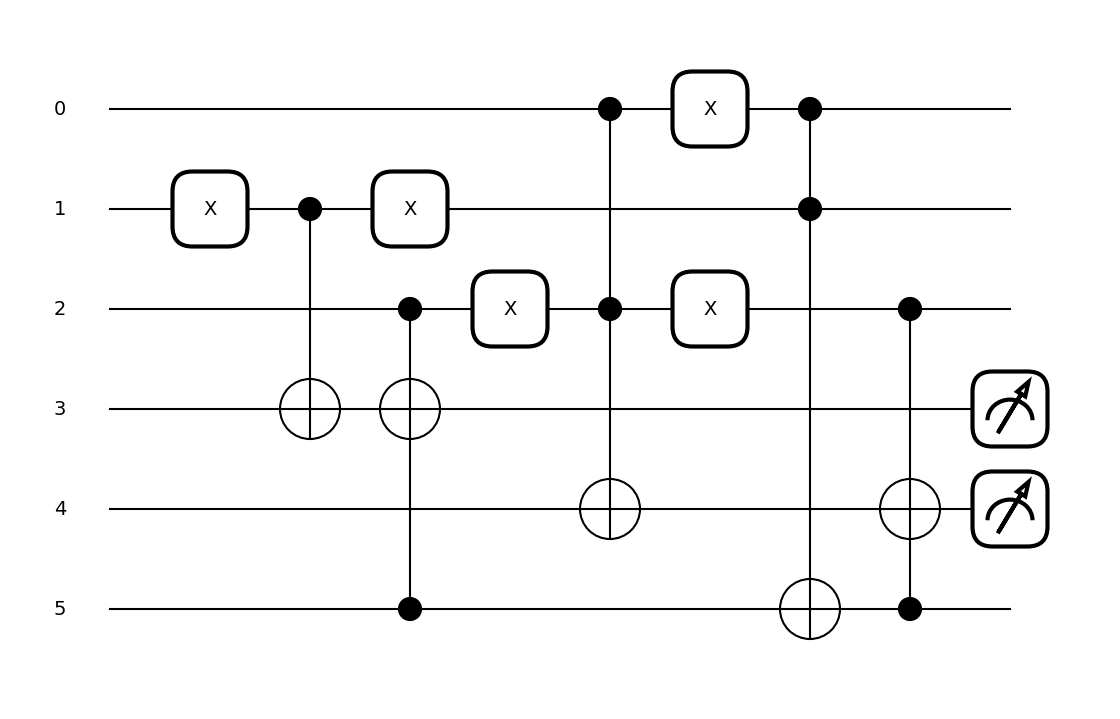

In [70]:
# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
qml.draw_mpl(oracle_circuit)([0, 0, 0])
plt.show()